In [10]:
# Necessary imports

%matplotlib inline
import torch
import torch.nn as nn
from torchvision import datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import scipy.signal as spsig
import scipy.signal.windows as spwin

import random
import os
import librosa
import librosa.display

from PIL import Image

import csv


## Generate Spectrograms
Basically convert a .wav or .mp3

AttributeError: 'Figure' object has no attribute 'get_renderer'

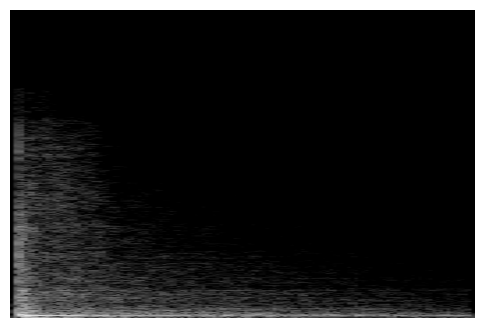

In [13]:
# Create spectrograms

# array of sound types available
sound_types = ["Snare", "Trumpet", "Violin"]

# iterate over each of the sound types
for sound_type in sound_types:

    # establish output directories
    # TODO: Add checks that directorties exist
    sound_dir = os.fsencode("../Sounds/" + sound_type)
    spec_dir = os.fsencode("../Spectrograms/" + sound_type)
    
    # remove all existing spectrograms
    for spec_file in os.listdir(spec_dir):
        filename = os.fsdecode(spec_file)
        if filename.endswith(".png"):
            os.remove(os.path.join(spec_dir, spec_file))


    # iterate over each file (in each directory)
    for sound_file in os.listdir(sound_dir):
        filename = os.fsdecode(sound_file)

        # filter out audio files
        if filename.endswith(".wav") or filename.endswith(".mp3" or filename.endswith(".flac")):
            
            # load sound files
            # librosa is convenient because it resamples and downscales to mono automatically
            y_orig, fs = librosa.load(os.path.join(sound_dir, sound_file), mono=True, sr=48000)

            # set output time and corresponding number of samples
            output_time = 1 # seconds
            output_len = output_time * fs

            # number of samples of loaded file
            input_len = np.shape(y_orig)[0]

            # skip if loaded file is too short analyse
            if input_len < output_len:
                print(filename, "is too short, skipping conversion")
                continue
            
            # find a section with a high rms value
            jump = output_len//2 # spacing between sections
            rms_best = 0
            rms_best_start = 0

            # loop over sections of the sample to find the big with the best rms value
            for start in range(0, input_len - output_len, jump):
                end = start + output_len
                rms = np.sqrt(np.mean(np.square(y_orig[start:end])))
                if rms > rms_best:
                    rms_best = rms
                    rms_best_start = start

            # window with best RMS value
            y = y_orig[rms_best_start:rms_best_start + output_len]

            # Compute the Short-Time Fourier Transform (STFT)
            # D = librosa.stft(y)

            # STFT calc for spectrogramss

            imgsize = 128

            T_x, N = 1 / fs, output_len  # 20 Hz sampling rate for 50 s signal

            t_x = np.arange(N) * T_x  # time indexes for signal


            win = np.ones(1024)#spwin.hamming(1000) 
            hop = output_len//imgsize

            # SFT = spsig.ShortTimeFFT(win, hop=hop, fs=fs, mfft=16000, scale_to='psd')
            SFT = spsig.ShortTimeFFT(win, hop=hop, fs=fs, scale_to='psd')

            Sx2 = SFT.spectrogram(y)  # calculate absolute square of STFT

            Sx_dB = 10 * np.log10(np.fmax(Sx2, 5e-9))  # limit range to ~-83dB

            fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
            im1 = ax1.imshow(Sx_dB, origin='lower', aspect='auto', extent=SFT.extent(N), cmap='gray')


            output_file = os.path.join(spec_dir, os.fsencode(os.path.splitext(filename)[0] + ".png"))
            plt.axis("off")

            plt.savefig(output_file, bbox_inches='tight', pad_inches=0)        
            plt.close()

In [13]:


# Create arrays of ground truth data

sound_types = ["Snare", "Trumpet", "Violin"]

data = []

for sound_type in sound_types:

    # establish output directories
    # TODO: Add checks that directorties exist
    spec_dir = os.fsencode("../Spectrograms/" + sound_type)
    
    # remove all existing spectrograms
    for spec_file in os.listdir(spec_dir):
        
        filename = os.fsdecode(spec_file)
        
        if filename.endswith(".png"):

            data.append([os.fsdecode(os.path.join(spec_dir, spec_file)), sound_type])

key = lambda row: row[0] 

data.sort(key=lambda item: item[0])

with open('groundtruthdata.csv', 'w+') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows(data)

## Create dataset class


In [22]:
import pandas as pd
# from skimage import io, transform
from torchvision import io
from torch.utils.data import Dataset, DataLoader

class InstrumentsDataset(Dataset):
    """Instruments dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.instrument_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.instrument_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.instrument_frame.iloc[idx, 0])
        image = io.read_image(img_name)
        instrument = self.instrument_frame.iloc[idx, 1]


        if self.transform:
            sample = self.transform(sample)

        return image, instrument


In [23]:
instruments_dataset = InstrumentsDataset(csv_file = "groundtruthdata.csv", root_dir = ".")

# for i, sample in enumerate(instruments_dataset):
#     print(i, sample['image'].shape, sample['instrument'])

train_size = int(0.8 * len(instruments_dataset))
test_size = len(instruments_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(instruments_dataset, [train_size, test_size])

0 (369, 496, 4) Snare
1 (369, 496, 4) Snare
2 (369, 496, 4) Snare
3 (369, 496, 4) Snare
4 (369, 496, 4) Snare
5 (369, 496, 4) Snare
6 (369, 496, 4) Snare
7 (369, 496, 4) Snare
8 (369, 496, 4) Snare
9 (369, 496, 4) Snare
10 (369, 496, 4) Snare
11 (369, 496, 4) Snare
12 (369, 496, 4) Snare
13 (369, 496, 4) Snare
14 (369, 496, 4) Snare
15 (369, 496, 4) Snare
16 (369, 496, 4) Snare
17 (369, 496, 4) Snare
18 (369, 496, 4) Snare
19 (369, 496, 4) Snare
20 (369, 496, 4) Snare
21 (369, 496, 4) Snare
22 (369, 496, 4) Snare
23 (369, 496, 4) Snare
24 (369, 496, 4) Snare
25 (369, 496, 4) Snare
26 (369, 496, 4) Snare
27 (369, 496, 4) Snare
28 (369, 496, 4) Snare
29 (369, 496, 4) Snare
30 (369, 496, 4) Snare
31 (369, 496, 4) Snare
32 (369, 496, 4) Snare
33 (369, 496, 4) Snare
34 (369, 496, 4) Snare
35 (369, 496, 4) Snare
36 (369, 496, 4) Snare
37 (369, 496, 4) Snare
38 (369, 496, 4) Snare
39 (369, 496, 4) Snare
40 (369, 496, 4) Snare
41 (369, 496, 4) Snare
42 (369, 496, 4) Snare
43 (369, 496, 4) Snar